# S2 - Spatial transferbility

Transfer the trained model to predict data from Weser Ems in 2013, 2014, 2015, 2016, 2018

### 1.0 Loading libraries and setting path

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
import skopt

from tensorflow.keras.models import load_model
import joblib

2023-06-22 22:29:41.866402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 22:29:42.537596: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-06-22 22:29:42.537667: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/

In [3]:
os.chdir('/home/pc4dl/SYM2')

In [4]:
print("Tensorflow Version: ", tf. __version__) 
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.11.0
Tensorflow Probability Version:  0.18.0


### 2.0 Define functions for reading, prepare and visualising data

In [5]:
def preapre_df(df):
    """
    This function read the dataframe and filter out the unwanted years and generate seperate
    dataframes for a) only with SR bands, b) only with VIs, and c) both with SR bands & VIs.
    """
    year_list = [*range(2010, 2019, 1)]
    df_years = df[df['year'].isin(year_list)]
    df_dropna = df_years.dropna()
    
    df_sr = df_dropna.iloc[:, [0, 47, 5,  
                               7, 8, 9, 10, 11, 12, 
                               17, 18, 19, 20, 21, 22, 
                               27, 28, 29, 30, 31, 32, 
                               37, 38, 39, 40, 41, 42]]
    
    df_vi = df_dropna.iloc[:, [0, 47, 5,  
                               13, 14, 15, 16, 
                               23, 24, 25, 26, 
                               33, 34, 35, 36, 
                               43, 44, 45, 46]]
    df_sr_vi = df_dropna.iloc[:, [0, 47, 5,  
                               7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
                               17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 
                               27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 
                               37, 38, 39, 40, 41, 42, 43, 44, 45, 46]]
    
    return df_sr, df_vi, df_sr_vi

def s2_df(df):
    
    df2 = df.copy()
    
    non_test_years = [2010, 2011, 2012]
    
    df_y = df2[~df2['year'].isin(non_test_years)]
    
    return df_y


def norm(df):
    MIN = df.min(1)
    MAX = df.max(1)
    return df.sub(MIN, 0).div(MAX-MIN, 0)


def s_df_np(df):
    """
    This function convert dataframes to numpy arrays.
    """
    
    df_X = df.iloc[:, 3:43] # norm(df.iloc[:, 3:43])
    np_X = df_X.to_numpy()
    
    np_X = np.transpose(np_X.reshape(np_X.shape[0], 4, 10), (0, 2, 1))
    np_X = np.expand_dims(np_X, axis=3)
    
    np_Y = df.iloc[:, 2].to_numpy()
    
    return df_X, np_X, np_Y

def cl_levels(npa):
    """
    This function recreate generated label numpy arrays according to two different class levels.
    CL1 is for 3 classes - 0: Other, 1: Maize, 2: Grasslands
    CL2 is for 5 classes - 0: Other, 1: Maize, 2: Grasslands, 3: Summer crops, 4: Winter Crops
    """
    cl2_np = npa.copy()
    cl1_np = npa.copy()
    
    cl2_np[cl2_np == 'OT'] = 0
    cl2_np[cl2_np == 'MZ'] = 1
    cl2_np[cl2_np == 'PG'] = 2
    cl2_np[cl2_np == 'SC'] = 3
    cl2_np[cl2_np == 'WC'] = 4
    cl2_np[cl2_np == 'TG'] = 2
    
    cl1_np[cl1_np == 'OT'] = 0
    cl1_np[cl1_np == 'MZ'] = 1
    cl1_np[cl1_np == 'PG'] = 2
    cl1_np[cl1_np == 'SC'] = 0
    cl1_np[cl1_np == 'WC'] = 0
    cl1_np[cl1_np == 'TG'] = 2
    
    cl1_np = np.asarray(cl1_np).astype('float32')
    cl2_np = np.asarray(cl2_np).astype('float32')
    
    return cl1_np, cl2_np

def cl_print(cl_np):
    """
    This function prints the frequency of each class.
    """
    tst_u_cl, tst_u_frq = np.unique(cl_np, return_counts=True)
    tst_u_cl_frq = zip(tst_u_cl, tst_u_frq)
    for elem in tst_u_cl_frq:
        print(elem[0], ' Occurs :', elem[1], ' times')
    print('########################')

In [6]:
cl1_names={ 0: 'Other', 1: 'Maize', 2: 'Grasslands'}
cl2_names={ 0: 'Other', 1: 'Maize', 2: 'Grasslands', 3: 'Summer Crops', 4: 'Winter Crops'}

In [7]:
def visualize_batch(data_X, data_Y1, data_Y2, cls1, cls2, tv=None):
    rnd = random.sample(range(10, data_X.shape[0]), 25)
    # initialize a figure
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(tv, fontsize=16)
    # loop over the batch size
    for i in range(25):
        # create a subplot
        ax = plt.subplot(5, 5, i + 1)
        mat = data_X[rnd[i]]
        # grab the label id and get the label from the classes list
        idx_1 = data_Y1[rnd[i]]
        idx_2 = data_Y2[rnd[i]]
        label_1 = cls1[idx_1]
        label_2 = cls2[idx_2]
        label = "CL1: " + label_1 + "\nCL2: " + label_2
        # show the image along with the label
        plt.imshow(mat, cmap='viridis')
        plt.title(label)
        plt.axis("off")
        # show the plot
    plt.tight_layout()
    plt.show()

## 3.0 Read data

In [8]:
# Read CSVs

nh_l578 = pd.read_csv(r'./OriginalData_NH/L578_extract/NH_L578_all_norm.csv')
we_l578 = pd.read_csv(r'./OriginalData_WE/L578_extract/WE_L578_all_norm.csv')

year_list = [*range(2010, 2019, 1)]

### 3.1 Prepare data

In [9]:
# Prepare dataframes and generate seperate dataframes

nh_l578_sr, nh_l578_vi, nh_l578_sr_vi = preapre_df(nh_l578)
we_l578_sr, we_l578_vi, we_l578_sr_vi = preapre_df(we_l578)

# 2.0 Data for testing in Scenario 1 (Model trained in Location A + Time T1 --> Test in Location A + Time T2)

s2_nh_test_df = s2_df(nh_l578_sr_vi)
s2_we_test_df = s2_df(we_l578_sr_vi)


# Create necessary DF and NPs
s2_nh_test_X_df, s2_nh_test_X_np, s2_nh_test_Y_np = s_df_np(s2_nh_test_df)
s2_we_test_X_df, s2_we_test_X_np, s2_we_test_Y_np = s_df_np(s2_we_test_df)

# Create two levels of Y
s2_nh_test_Y_np_cl1, s2_nh_test_Y_np_cl2 = cl_levels(s2_nh_test_Y_np)
s2_we_test_Y_np_cl1, s2_we_test_Y_np_cl2 = cl_levels(s2_we_test_Y_np)

cl_print(s2_nh_test_Y_np_cl1)
cl_print(s2_nh_test_Y_np_cl2)

cl_print(s2_we_test_Y_np_cl1)
cl_print(s2_we_test_Y_np_cl2)

0.0  Occurs : 305490  times
1.0  Occurs : 36395  times
2.0  Occurs : 187907  times
########################
0.0  Occurs : 22997  times
1.0  Occurs : 36395  times
2.0  Occurs : 187907  times
3.0  Occurs : 35414  times
4.0  Occurs : 247079  times
########################
0.0  Occurs : 399177  times
1.0  Occurs : 441576  times
2.0  Occurs : 703976  times
########################
0.0  Occurs : 19990  times
1.0  Occurs : 441576  times
2.0  Occurs : 703976  times
3.0  Occurs : 102446  times
4.0  Occurs : 276741  times
########################


In [10]:
# shape of the training and validation set
print('Shape of the S2 testing dataset \n Train X: ' + str(s2_nh_test_X_np.shape))
print('Shape of the S2 testing dataset \n Train Y (CL1): ' + str(s2_nh_test_Y_np_cl1.shape))
print('Shape of the S2 testing dataset \n Train Y (CL2): ' + str(s2_nh_test_Y_np_cl2.shape))

Shape of the S2 testing dataset 
 Train X: (529792, 10, 4, 1)
Shape of the S2 testing dataset 
 Train Y (CL1): (529792,)
Shape of the S2 testing dataset 
 Train Y (CL2): (529792,)


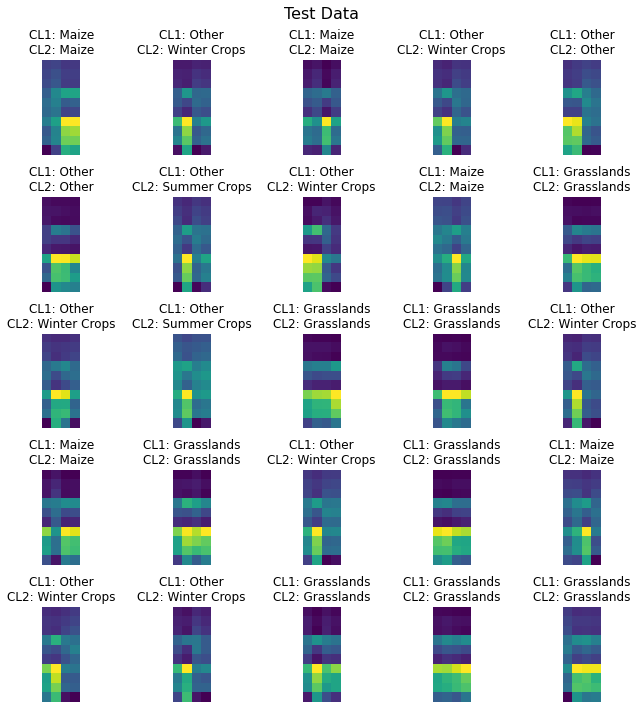

In [11]:
visualize_batch(s2_nh_test_X_np, s2_nh_test_Y_np_cl1, s2_nh_test_Y_np_cl2, cl1_names, cl2_names, "Test Data")

### 3.2 DI and AOA

In [12]:
from sklearn.neighbors import BallTree
from scipy.spatial.distance import pdist, squareform
def aoa(new_data, 
        training_data, 
        model=None, 
        thres=0.95,
        fold_indices=None,
        distance_metric='euclidean'
       ):
    """
    Area of Applicability (AOA) measure for spatial prediction models from
    Meyer and Pebesma (2020). The AOA defines the area for which, on average, 
    the cross-validation error of the model applies, which is crucial for 
    cases where spatial predictions are used to inform decision-making.
    
    Parameters
    ----------
    new_data : GeoDataFrame
        A GeoDataFrame containing unseen data to measure AOA for.
    training_data : GeoDataFrame
        A GeoDataFrame containing the features used for model training.
    thres : default=0.95
        Threshold used to identify predictive area of applicability.
    fold_indices : iterable, default=None
        iterable consisting of training indices that identify instances in the
        folds.
    distance_metric : string, default='euclidean'
        Distance metric to calculate distances between new_data and training_data.
        Defaults to euclidean for projected CRS, otherwise haversine for unprojected.
    Returns
    -------
    DIs : array
        Array of disimimilarity scores between training_data for new_data points.
    masked_result : array
        Binary mask that occludes points outside predictive area of applicability.
    """
    
    
    if len(training_data) <= 1:
        raise Exception('At least two training instances need to be specified.')
                    
    # Scale data 
    training_data = (training_data - np.mean(training_data)) / np.std(training_data)
    new_data = (new_data - np.mean(new_data)) / np.std(new_data)

    # Calculate nearest training instance to test data, return Euclidean distances
    tree = BallTree(training_data, metric=distance_metric) 
    mindist, _ = tree.query(new_data, k=1, return_distance=True)

    # Build matrix of pairwise distances 
    paired_distances = pdist(training_data)
    train_dist = squareform(paired_distances)
    np.fill_diagonal(train_dist, np.nan)
    
    # Remove data points that are within the same fold
    if fold_indices:            
        # Get number of training instances in each fold
        instances_in_folds = [len(fold) for fold in fold_indices]
        instance_fold_id = np.repeat(np.arange(0, len(fold_indices)), instances_in_folds)

        # Create mapping between training instance and fold ID
        fold_indices = np.concatenate(fold_indices)
        folds = np.vstack((fold_indices, instance_fold_id)).T

        # Mask training points in same fold for DI measure calculation
        for i, row in enumerate(train_dist):
            mask = folds[:,0] == folds[:,0][i]
            train_dist[i, mask] = np.nan

    # Scale distance to nearest training point by average distance across training data
    train_dist_mean = np.nanmean(train_dist, axis=1)
    train_dist_avgmean = np.mean(train_dist_mean)
    mindist /= train_dist_avgmean    

    # Define threshold for AOA
    train_dist_min = np.nanmin(train_dist, axis=1)
    aoa_train_stats = np.quantile(train_dist_min / train_dist_avgmean, 
                                    q = np.array([0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]))
    thres = np.quantile(train_dist_min / train_dist_avgmean, q = thres)
    
    # We choose the AOA as the area where the DI does not exceed the threshold
    DIs = mindist.reshape(-1)
    masked_result = np.repeat(1, len(mindist))
    masked_result[DIs > thres] = 0

    return DIs, masked_result, thres

In [13]:
org_train_data = pd.read_csv(r'./OriginalData_WE/L578_extract/s_we_train_df.csv')
org_train_data = org_train_data.iloc[: , 1:]
# org_train_data

In [14]:
DI, Masked, thres = aoa(new_data=s2_nh_test_X_df, 
        training_data=org_train_data, 
        model=None, 
        thres=0.95,
        fold_indices=None,
        distance_metric='euclidean'
       )

In [15]:
thres

0.32091374832106373

In [16]:
unique, counts = np.unique(Masked, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0  69288]
 [     1 370668]]


## 4.0 Load Models

In [12]:
# CNN
deterministic_model_cl1 = load_model('./Out/CNN_Models/dcnn_model_we_cl1_trained.hdf5', compile=False)
deterministic_model_cl2 = load_model('./Out/CNN_Models/dcnn_model_we_cl2_trained.hdf5', compile=False)

# RF
rf_model_cl1 = joblib.load("./Out/RF_Models/rf_model_we_cl1_trained.joblib")
rf_model_cl2 = joblib.load("./Out/RF_Models/rf_model_we_cl2_trained.joblib")

2023-06-22 22:30:22.642507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 22:30:22.642921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 22:30:22.648218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 22:30:22.648661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 22:30:22.649036: I tensorflow/compiler/xla/stream_executo

## 5.0 Test Models

### 5.1 CNN model test

In [13]:
# Check traget system accuracy

cnn_model_s2_nh_test_cl1_y_pred = deterministic_model_cl1.predict(s2_nh_test_X_np)
cnn_model_s2_nh_test_cl2_y_pred = deterministic_model_cl2.predict(s2_nh_test_X_np)
# Convert predictions classes to one hot vectors
cnn_model_s2_nh_test_cl1_y_pred_classes = np.argmax(cnn_model_s2_nh_test_cl1_y_pred, axis = 1) 
cnn_model_s2_nh_test_cl2_y_pred_classes = np.argmax(cnn_model_s2_nh_test_cl2_y_pred, axis = 1)
# Convert test data to one hot vectors
cnn_model_s2_nh_test_cl1_y_true = s2_nh_test_Y_np_cl1
cnn_model_s2_nh_test_cl2_y_true = s2_nh_test_Y_np_cl2

# CM
cnn_model_s2_nh_test_cl1_cm = confusion_matrix(cnn_model_s2_nh_test_cl1_y_true, cnn_model_s2_nh_test_cl1_y_pred_classes)
cnn_model_s2_nh_test_cl2_cm = confusion_matrix(cnn_model_s2_nh_test_cl2_y_true, cnn_model_s2_nh_test_cl2_y_pred_classes)

# Accuracy
cnn_model_s2_nh_test_cl1_acc = accuracy_score(y_true=cnn_model_s2_nh_test_cl1_y_true, y_pred=cnn_model_s2_nh_test_cl1_y_pred_classes, normalize=True)
cnn_model_s2_nh_test_cl2_acc = accuracy_score(y_true=cnn_model_s2_nh_test_cl2_y_true, y_pred=cnn_model_s2_nh_test_cl2_y_pred_classes, normalize=True)

# Macro F1
cnn_model_s2_nh_test_cl1_macroF1 = f1_score(y_true=cnn_model_s2_nh_test_cl1_y_true, y_pred=cnn_model_s2_nh_test_cl1_y_pred_classes, average='macro')
cnn_model_s2_nh_test_cl2_macroF1 = f1_score(y_true=cnn_model_s2_nh_test_cl2_y_true, y_pred=cnn_model_s2_nh_test_cl2_y_pred_classes, average='macro')

print("=================================\n")
print('S2 CNN WE Model CL1 Test')
print(cnn_model_s2_nh_test_cl1_cm)
print("Test accuracy for S2 CNN WE model for CL1: " + str(round(cnn_model_s2_nh_test_cl1_acc, 3)))
print("Test MacroF1 for S2 CNN WE model for CL1: " + str(round(cnn_model_s2_nh_test_cl1_macroF1, 3)))
print("=================================\n")
print('S2 CNN WE Model CL2 Test')
print(cnn_model_s2_nh_test_cl2_cm)
print("Test accuracy for S2 CNN WE model for CL2: " + str(round(cnn_model_s2_nh_test_cl2_acc, 3)))
print("Test MacroF1 for S2 CNN WE model for CL2: " + str(round(cnn_model_s2_nh_test_cl2_macroF1, 3)))

2023-06-22 22:30:27.904145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


16556/16556 [==============================] - 20s 1ms/step

S2 CNN WE Model CL1 Test
[[298891   1340   5259]
 [ 17426  18771    198]
 [ 49541     92 138274]]
Test accuracy for S2 CNN WE model for CL1: 0.861
Test MacroF1 for S2 CNN WE model for CL1: 0.796

S2 CNN WE Model CL2 Test
[[ 13666    419   2474   2208   4230]
 [  4548  21117    165   9641    924]
 [ 70709    242 112619   1306   3031]
 [  3250    619    219  27990   3336]
 [  4943    111    426  16781 224818]]
Test accuracy for S2 CNN WE model for CL2: 0.755
Test MacroF1 for S2 CNN WE model for CL2: 0.643


In [14]:
cnn_model_s2_nh_test_cl1_clsF1 = f1_score(y_true=cnn_model_s2_nh_test_cl1_y_true, y_pred=cnn_model_s2_nh_test_cl1_y_pred_classes, average=None)

cnn_s2_cl1_f1 = [list(cl1_names.values()), cnn_model_s2_nh_test_cl1_clsF1.tolist()]
cnn_s2_cl1_f1_df = pd.DataFrame(cnn_s2_cl1_f1)
cnn_s2_cl1_f1_df = cnn_s2_cl1_f1_df.transpose()
 
# specifying column names
cnn_s2_cl1_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S2 CNN WE Model CL1 Test')
cnn_s2_cl1_f1_df



S2 CNN WE Model CL1 Test


,Class,F1
0,Other,0.89042
1,Maize,0.66331
2,Grasslands,0.833885


In [15]:
cnn_model_s2_nh_test_cl2_clsF1 = f1_score(y_true=cnn_model_s2_nh_test_cl2_y_true, y_pred=cnn_model_s2_nh_test_cl2_y_pred_classes, average=None)

cnn_s2_cl2_f1 = [list(cl2_names.values()), cnn_model_s2_nh_test_cl2_clsF1.tolist()]
cnn_s2_cl2_f1_df = pd.DataFrame(cnn_s2_cl2_f1)
cnn_s2_cl2_f1_df = cnn_s2_cl2_f1_df.transpose()
 
# specifying column names
cnn_s2_cl2_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S2 CNN WE Model CL2 Test')
cnn_s2_cl2_f1_df



S2 CNN WE Model CL2 Test


,Class,F1
0,Other,0.227552
1,Maize,0.717009
2,Grasslands,0.741378
3,Summer Crops,0.599743
4,Winter Crops,0.930118


### 5.2 RF Model Test

In [16]:
# Check target system accuracy

rf_model_s2_nh_test_cl1_y_pred = rf_model_cl1.predict(s2_nh_test_X_df)
rf_model_s2_nh_test_cl2_y_pred = rf_model_cl2.predict(s2_nh_test_X_df)

# Convert predictions classes to one hot vectors 9
rf_model_s2_nh_test_cl1_y_pred_classes = rf_model_s2_nh_test_cl1_y_pred # np.argmax(rf_model_s2_nh_test_cl1_y_pred, axis = 1) 
rf_model_s2_nh_test_cl2_y_pred_classes = rf_model_s2_nh_test_cl2_y_pred # np.argmax(rf_model_s2_nh_test_cl2_y_pred, axis = 1)
# Convert test data to one hot vectors
rf_model_s2_nh_test_cl1_y_true = s2_nh_test_Y_np_cl1
rf_model_s2_nh_test_cl2_y_true = s2_nh_test_Y_np_cl2

# CM
rf_model_s2_nh_test_cl1_cm = confusion_matrix(rf_model_s2_nh_test_cl1_y_true, rf_model_s2_nh_test_cl1_y_pred_classes)
rf_model_s2_nh_test_cl2_cm = confusion_matrix(rf_model_s2_nh_test_cl2_y_true, rf_model_s2_nh_test_cl2_y_pred_classes)

# Accuracy
rf_model_s2_nh_test_cl1_acc = accuracy_score(y_true=rf_model_s2_nh_test_cl1_y_true, y_pred=rf_model_s2_nh_test_cl1_y_pred_classes, normalize=True)
rf_model_s2_nh_test_cl2_acc = accuracy_score(y_true=rf_model_s2_nh_test_cl2_y_true, y_pred=rf_model_s2_nh_test_cl2_y_pred_classes, normalize=True)

# Macro F1
rf_model_s2_nh_test_cl1_macroF1 = f1_score(y_true=rf_model_s2_nh_test_cl1_y_true, y_pred=rf_model_s2_nh_test_cl1_y_pred_classes, average='macro')
rf_model_s2_nh_test_cl2_macroF1 = f1_score(y_true=rf_model_s2_nh_test_cl2_y_true, y_pred=rf_model_s2_nh_test_cl2_y_pred_classes, average='macro')

print("=================================\n")
print('S2 RF WE Model CL1 Test')
print(rf_model_s2_nh_test_cl1_cm)
print("Test accuracy for S2 RF WE model for CL1: " + str(round(rf_model_s2_nh_test_cl1_acc, 3)))
print("Test MacroF1 for S2 RF WE model for CL1: " + str(round(rf_model_s2_nh_test_cl1_macroF1, 3)))
print("=================================\n")
print('S2 RF WE Model CL2 Test')
print(rf_model_s2_nh_test_cl2_cm)
print("Test accuracy for S2 RF WE model for CL2: " + str(round(rf_model_s2_nh_test_cl2_acc, 3)))
print("Test MacroF1 for S2 RF WE model for CL2: " + str(round(rf_model_s2_nh_test_cl2_macroF1, 3)))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    4.6s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    6.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    5.8s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    8.1s finished



S2 RF WE Model CL1 Test
[[300036    939   4515]
 [ 15543  20393    459]
 [ 55501    232 132174]]
Test accuracy for S2 RF WE model for CL1: 0.854
Test MacroF1 for S2 RF WE model for CL1: 0.801

S2 RF WE Model CL2 Test
[[  9743    486   4866   2579   5323]
 [  4389  22777    629   8266    334]
 [ 31729    332 146360   2240   7246]
 [  3863   1122    463  26037   3929]
 [  2607    113   1074  12596 230689]]
Test accuracy for S2 RF WE model for CL2: 0.822
Test MacroF1 for S2 RF WE model for CL2: 0.678


In [17]:
rf_model_s2_nh_test_cl1_clsF1 = f1_score(y_true=rf_model_s2_nh_test_cl1_y_true, y_pred=rf_model_s2_nh_test_cl1_y_pred_classes, average=None)

rf_s2_cl1_f1 = [list(cl1_names.values()), rf_model_s2_nh_test_cl1_clsF1.tolist()]
rf_s2_cl1_f1_df = pd.DataFrame(rf_s2_cl1_f1)
rf_s2_cl1_f1_df = rf_s2_cl1_f1_df.transpose()
 
# specifying column names
rf_s2_cl1_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S2 RF WE Model CL1 Test')
rf_s2_cl1_f1_df



S2 RF WE Model CL1 Test


,Class,F1
0,Other,0.886933
1,Maize,0.703704
2,Grasslands,0.813241


In [18]:
rf_model_s2_nh_test_cl2_clsF1 = f1_score(y_true=rf_model_s2_nh_test_cl2_y_true, y_pred=rf_model_s2_nh_test_cl2_y_pred_classes, average=None)

rf_s2_cl2_f1 = [list(cl2_names.values()), rf_model_s2_nh_test_cl2_clsF1.tolist()]
rf_s2_cl2_f1_df = pd.DataFrame(rf_s2_cl2_f1)
rf_s2_cl2_f1_df = rf_s2_cl2_f1_df.transpose()
 
# specifying column names
rf_s2_cl2_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S2 RF WE Model CL2 Test')
rf_s2_cl2_f1_df



S2 RF WE Model CL2 Test


,Class,F1
0,Other,0.258682
1,Maize,0.744042
2,Grasslands,0.857664
3,Summer Crops,0.597645
4,Winter Crops,0.932831


## 6.0 Get model outputs

In [19]:
s2_base = s2_nh_test_df.iloc[:, [0, 1, 2]]
s2_base

,p_id,year,CAT
466469,2013_000001,2013,WC
466470,2013_000002,2013,WC
466471,2013_000003,2013,PG
466472,2013_000004,2013,WC
466473,2013_000005,2013,WC
...,...,...,...
1001191,2018_096098,2018,PG
1001192,2018_096099,2018,WC
1001193,2018_096100,2018,WC
1001194,2018_096101,2018,WC


### 6.1 CNN

In [20]:
s2_cnn_out_df = s2_base.copy()

s2_cnn_out_df['cl1_true'] = (np.array(cnn_model_s2_nh_test_cl1_y_true, int)).tolist()

s2_cnn_out_df['cl1_pred'] = cnn_model_s2_nh_test_cl1_y_pred_classes.tolist()

s2_cnn_out_df['cl2_true'] = (np.array(cnn_model_s2_nh_test_cl2_y_true, int)).tolist()

s2_cnn_out_df['cl2_pred'] = cnn_model_s2_nh_test_cl2_y_pred_classes.tolist()

# s2_cnn_out_df['DI'] = DI.tolist()

# s2_cnn_out_df['AOA'] = Masked.tolist()

s2_cnn_out_df

,p_id,year,CAT,cl1_true,cl1_pred,cl2_true,cl2_pred
466469,2013_000001,2013,WC,0,0,4,4
466470,2013_000002,2013,WC,0,0,4,4
466471,2013_000003,2013,PG,2,2,2,2
466472,2013_000004,2013,WC,0,0,4,3
466473,2013_000005,2013,WC,0,0,4,4
...,...,...,...,...,...,...,...
1001191,2018_096098,2018,PG,2,0,2,4
1001192,2018_096099,2018,WC,0,0,4,4
1001193,2018_096100,2018,WC,0,0,4,4
1001194,2018_096101,2018,WC,0,0,4,4


In [21]:
s2_cnn_out_df.to_csv('./Out/CNN_Models/s2_WE_cnn_out.csv')

### 6.2 RF

In [22]:
s2_rf_out_df = s2_base.copy()

s2_rf_out_df['cl1_true'] = (np.array(rf_model_s2_nh_test_cl1_y_true, int)).tolist()

s2_rf_out_df['cl1_pred'] = rf_model_s2_nh_test_cl1_y_pred_classes.tolist()

s2_rf_out_df['cl2_true'] = (np.array(rf_model_s2_nh_test_cl2_y_true, int)).tolist()

s2_rf_out_df['cl2_pred'] = rf_model_s2_nh_test_cl2_y_pred_classes.tolist()

# s2_rf_out_df['DI'] = DI.tolist()

# s2_rf_out_df['AOA'] = Masked.tolist()

s2_rf_out_df

,p_id,year,CAT,cl1_true,cl1_pred,cl2_true,cl2_pred
466469,2013_000001,2013,WC,0,0.0,4,4.0
466470,2013_000002,2013,WC,0,0.0,4,4.0
466471,2013_000003,2013,PG,2,2.0,2,2.0
466472,2013_000004,2013,WC,0,0.0,4,4.0
466473,2013_000005,2013,WC,0,0.0,4,4.0
...,...,...,...,...,...,...,...
1001191,2018_096098,2018,PG,2,0.0,2,4.0
1001192,2018_096099,2018,WC,0,0.0,4,4.0
1001193,2018_096100,2018,WC,0,0.0,4,4.0
1001194,2018_096101,2018,WC,0,0.0,4,4.0


In [23]:
s2_rf_out_df.to_csv('./Out/RF_Models/s2_WE_rf_out.csv')